# Online News

We want to create a regression model to predict the number of shares an online news feature will bring. This aims to help writers and editors determine when and what to release. Data were obtained and compiled from mashable.com.

- Fit an initial linear regression model on the dataset.
    - Remove any non-predictive variables such as url and timedelta. You may want to remove some of the min and max variables as they might skew the data unnecessarily or repeat the same data. State why you think they should be removed.
    - What is the p-value of the model? Coefficient of determination?
    - What are the coefficients of the ff. variables: data_channel_is_entertainment, weekday_is_tuesday, LDA_04
- Outlier Analysis and Model Validation.
    - Identify outliers in the dataset. Since we are dealing with multivariate analysis, measure them with indices of influence, leverage, or distance. Which articles are outliers?
    - Does the full model satisfy the constant variance assumption of regression? Prove your answer through graphs.
    - Analyze the residuals graphically and quantitatively. Check for independence of errors, normality of errors, sufficiency, multicollinearity, etc. What conclusions can you make from these graphs?
    - Transform your dataset. Does it change the number of outliers? Does it change the actual outliers? Check the graphs you made again to see any difference.
    - Reduce the original dataset by removing the identified outliers. Do Stepwise Regression on the reduced dataset.
        - Which of the variables are significant in the final iteration?
        - Write down the final reduced regression model with only the significant variables present.
        - Check the analysis graphs you made yet again to see any difference.
- Standardize the reduced dataset with significant variables.
    - Which variables are the most influential?
    - Which Data channel is the most influential? Least influential?
    - Which Day is the most influential? Least influential?
    - What LDA (topic) is the most influential? Least influential?
    - What is a good range of number of words in the title? Number of words in the content?
- Create the best-performing model. Use R2, MAPE, and RMSE as your metrics. Split the data first into training and testing sets.

### Import Libraries and Define Functions

In [ ]:
!pip install pandas_profiling shap dalex

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


#### Libraries

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy
from sklearn import set_config
import sklearn
set_config(display='diagram')
sns.set_style("whitegrid")
sns.set_context("poster")

%matplotlib inline

In [ ]:
from ydata_profiling import ProfileReport
from sklearn.metrics import make_scorer, r2_score, mean_absolute_percentage_error, mean_squared_error
from sklearn.covariance import MinCovDet
from scipy.stats import chi2
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.feature_selection import VarianceThreshold
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.linear_model import LinearRegression, Lasso, SGDRegressor, HuberRegressor
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel, RFE, SelectKBest, f_regression
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SequentialFeatureSelector
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

#### Functions

In [ ]:
def evaluate_model(name, model, X, y):
    """
    Evaluates a model on a dataset.

    Parameters
    ----------
    name : str
        Name of the model.
    model : sklearn model
        Model to evaluate.
    X : pandas.DataFrame
        Dataset to evaluate.
    y : pandas.Series
        Target of the dataset.

    Returns
    -------
    res : dict
        Dictionary with the results of the evaluation.

    """
    y_pred = model.predict(X)
    res = {'model': name}
    res['r2_score'] = r2_score(y, y_pred)
    res['mape'] = mean_absolute_percentage_error(y, y_pred)
    res['rmse'] = mean_squared_error(y, y_pred, squared=False)
    return res

In [ ]:
#Tukey's method
def tukeys_method(df, variable, problist, posslist):
    """
    Return indices of probable and possible outliers under column `variable`.
    """
    
    data = df.copy()
    
    # quartile 1
    q1 = df[variable].quantile(0.25)
    
    # quartile 3
    q3 = df[variable].quantile(0.75)
    
    #interquartile range
    iqr = q3 - q1
    
    # inner and outer fences
    inner_fence = 1.5 * iqr
    outer_fence = 3 * iqr
    
    # lower and upper bounds (inner fence)
    inner_fence_le = q1 - inner_fence
    inner_fence_ue = q3 + inner_fence
    
    # lower and upper bounds (outer fence)
    outer_fence_le = q1 - outer_fence
    outer_fence_ue = q3 + outer_fence


    # indices of outliers based on inner bounds
    outlier_poss = data[(data[variable] <= inner_fence_le) |
                        (data[variable] >= inner_fence_ue)].index
    for i in outlier_poss:
      if i not in posslist:
        posslist.append(i)
    
    # replace the outlier on inner bounds with NaN
    #df[(df[variable] <= inner_fence_le) | (df[variable] >= inner_fence_ue)] = np.nan
    
    # indices of outliers based on outer bounds
    outlier_prob = data[(data[variable] <= outer_fence_le) |
                        (data[variable] >= outer_fence_ue)].index
    for i in outlier_prob:
      if i not in problist:
        problist.append(i)

    # replace the outlier on outer bounds with NaN
    #df[(df[variable] <= outer_fence_le) | (df[variable] >= outer_fence_ue)] = np.nan
    for i in range(df.shape[0]):
      if (df.loc[i, variable] <= inner_fence_le) or (df.loc[i, variable] >= inner_fence_ue):
        df.loc[i,variable] = np.nan
    
    return (list(outlier_prob), list(outlier_poss))

In [ ]:
def target_outliers(df, variable=' shares'):
    # quartile 1
    q1 = df[variable].quantile(0.25)
    
    # quartile 3
    q3 = df[variable].quantile(0.75)
    
    #interquartile range
    iqr = q3 - q1
    
    # inner and outer fences
    inner_fence = 1.5 * iqr

    # lower and upper bounds (inner fence)
    inner_fence_le = q1 - inner_fence
    inner_fence_ue = q3 + inner_fence

    out_shares = df[(df[variable] <= inner_fence_le) |
                        (df[variable] >= inner_fence_ue)].index

    df1 = df[(df[variable] >= inner_fence_le) & (df[variable] <= inner_fence_ue)]
    return df1, out_shares


### Load and Explore the Data

In [ ]:
# Change directory to the file location of the dataset (Change as needed)
from google.colab import drive
drive.mount("/content/gdrive")
%cd '/content/gdrive/MyDrive/DSDP - Week 2/HW/Online News'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/.shortcut-targets-by-id/12NRD37N7hr7rCGwwDWij0WrB9n-HWyAx/DSDP - Week 2/HW/Online News


In [ ]:
# Putting the Data into a Data Frame
df = pd.read_csv('DSDP - OnlineNewsPopularity.csv')
df.head()

,url,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,...,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,shares
0,http://mashable.com/2013/01/07/amazon-instant-...,731.0,12.0,219.0,0.663594,1.0,0.815385,4.0,2.0,1.0,...,0.100000,0.7,-0.350000,-0.600,-0.200000,0.500000,-0.187500,0.000000,0.187500,593
1,http://mashable.com/2013/01/07/ap-samsung-spon...,731.0,9.0,255.0,0.604743,1.0,0.791946,3.0,1.0,1.0,...,0.033333,0.7,-0.118750,-0.125,-0.100000,0.000000,0.000000,0.500000,0.000000,711
2,http://mashable.com/2013/01/07/apple-40-billio...,731.0,9.0,211.0,0.575130,1.0,0.663866,3.0,1.0,1.0,...,0.100000,1.0,-0.466667,-0.800,-0.133333,0.000000,0.000000,0.500000,0.000000,1500
3,http://mashable.com/2013/01/07/astronaut-notre...,731.0,9.0,531.0,0.503788,1.0,0.665635,9.0,0.0,1.0,...,0.136364,0.8,-0.369697,-0.600,-0.166667,0.000000,0.000000,0.500000,0.000000,1200
4,http://mashable.com/2013/01/07/att-u-verse-apps/,731.0,13.0,1072.0,0.415646,1.0,0.540890,19.0,19.0,20.0,...,0.033333,1.0,-0.220192,-0.500,-0.050000,0.454545,0.136364,0.045455,0.136364,505


In [ ]:
# Inspect the Shape, Check for Nulls
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39644 entries, 0 to 39643
Data columns (total 61 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   url                             39644 non-null  object 
 1    timedelta                      39644 non-null  float64
 2    n_tokens_title                 39644 non-null  float64
 3    n_tokens_content               39644 non-null  float64
 4    n_unique_tokens                39644 non-null  float64
 5    n_non_stop_words               39644 non-null  float64
 6    n_non_stop_unique_tokens       39644 non-null  float64
 7    num_hrefs                      39644 non-null  float64
 8    num_self_hrefs                 39644 non-null  float64
 9    num_imgs                       39644 non-null  float64
 10   num_videos                     39644 non-null  float64
 11   average_token_length           39644 non-null  float64
 12   num_keywords                   

In [ ]:
# Check for duplicates
df.duplicated().value_counts()

False    39644
dtype: int64

In [ ]:
# Check the Summary Stats
df.describe()

,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,num_videos,...,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,shares
count,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,...,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000
mean,354.530471,10.398749,546.514731,0.548216,0.996469,0.689175,10.883690,3.293638,4.544143,1.249874,...,0.095446,0.756728,-0.259524,-0.521944,-0.107500,0.282353,0.071425,0.341843,0.156064,3395.380184
std,214.163767,2.114037,471.107508,3.520708,5.231231,3.264816,11.332017,3.855141,8.309434,4.107855,...,0.071315,0.247786,0.127726,0.290290,0.095373,0.324247,0.265450,0.188791,0.226294,11626.950749
min,8.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,-1.000000,-1.000000,-1.000000,0.000000,-1.000000,0.000000,0.000000,1.000000
25%,164.000000,9.000000,246.000000,0.470870,1.000000,0.625739,4.000000,1.000000,1.000000,0.000000,...,0.050000,0.600000,-0.328383,-0.700000,-0.125000,0.000000,0.000000,0.166667,0.000000,946.000000
50%,339.000000,10.000000,409.000000,0.539226,1.000000,0.690476,8.000000,3.000000,1.000000,0.000000,...,0.100000,0.800000,-0.253333,-0.500000,-0.100000,0.150000,0.000000,0.500000,0.000000,1400.000000
75%,542.000000,12.000000,716.000000,0.608696,1.000000,0.754630,14.000000,4.000000,4.000000,1.000000,...,0.100000,1.000000,-0.186905,-0.300000,-0.050000,0.500000,0.150000,0.500000,0.250000,2800.000000
max,731.000000,23.000000,8474.000000,701.000000,1042.000000,650.000000,304.000000,116.000000,128.000000,91.000000,...,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.500000,1.000000,843300.000000


In [ ]:
# Exhaustive Profiling
'''
profile = ProfileReport(df, title="Pandas Profiling Report", minimal=True)
profile.to_file("/content/gdrive/MyDrive/data-profiling.html")
'''

'\nprofile = ProfileReport(df, title="Pandas Profiling Report", minimal=True)\nprofile.to_file("/content/gdrive/MyDrive/data-profiling.html")\n'

From the exhaustive profiling using Pandas Profiling Report, the following are the main concerns:
- url has a high cardinality: 39644 distinct values	(High cardinality)
- n_unique_tokens is highly skewed (γ1 = 198.6551156)	(Skewed)
- n_non_stop_words is highly skewed (γ1 = 198.7924454)	(Skewed)
- n_non_stop_unique_tokens is highly skewed (γ1 = 198.4432944)	(Skewed)
- kw_max_min is highly skewed (γ1 = 35.32843373)	(Skewed)
- kw_avg_min is highly skewed (γ1 = 31.3061081)	(Skewed)
- self_reference_min_shares is highly skewed (γ1 = 26.26436416)	(Skewed)
- shares is highly skewed (γ1 = 33.96388488)	(Skewed)
- url has unique values	(Unique)


Since the shares column is the target feature, it can be ignored. The url is a non-predictive variable along with the timedelta, hence, they can be removed. The rest of the skewed features can also be removed as they might affect the models.

### Building the Pipeline

#### Train-Test Split

In [ ]:
X = df.drop([' shares'], axis=1)
y = df[' shares']
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.25,random_state=20)

#### Linear Regression Model

In [ ]:
preproc = ColumnTransformer(
    transformers=[
        ('url_and_others', 'drop', ['url', ' timedelta', ' n_unique_tokens', ' n_non_stop_words', ' n_non_stop_unique_tokens', 
                                    ' kw_max_min', ' kw_avg_min', ' self_reference_min_shares']),
        #('numerical', 'passthrough', make_column_selector(dtype_include=['float64']) )
    ],
    remainder='passthrough'
)
preproc

ColumnTransformer(remainder='passthrough',
                  transformers=[('url_and_others', 'drop',
                                 ['url', ' timedelta', ' n_unique_tokens',
                                  ' n_non_stop_words',
                                  ' n_non_stop_unique_tokens', ' kw_max_min',
                                  ' kw_avg_min',
                                  ' self_reference_min_shares'])])

In [ ]:
lin_pipe = Pipeline(
    steps=[
        ('preproc', preproc),
        ('variance', VarianceThreshold()),
        ('scaler', StandardScaler()),
        #('selector', SequentialFeatureSelector(LinearRegression(), n_features_to_select=51, scoring='r2', cv=None)),
        ('regressor', LinearRegression())
    ]
)

In [ ]:
lin_pipe.fit(X_train, y_train)

Pipeline(steps=[('preproc',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('url_and_others', 'drop',
                                                  ['url', ' timedelta',
                                                   ' n_unique_tokens',
                                                   ' n_non_stop_words',
                                                   ' n_non_stop_unique_tokens',
                                                   ' kw_max_min', ' kw_avg_min',
                                                   ' '
                                                   'self_reference_min_shares'])])),
                ('variance', VarianceThreshold()), ('scaler', StandardScaler()),
                ('regressor', LinearRegression())])

In [ ]:
res = []
res.append(
    evaluate_model(
        'Linear Regression (w/ Outliers)', lin_pipe, X_test, y_test
    )
)
res[-1]

{'model': 'Linear Regression (w/ Outliers)',
 'r2_score': 0.03007661960722452,
 'mape': 1.661045104520342,
 'rmse': 7155.587523056521}

##### P-values

In [ ]:
f, p = f_regression(X_train.drop(columns='url'), y_train)
pd.DataFrame(p, columns=["p-values"], index=X_train.drop(columns='url').columns)

,p-values
timedelta,8.102488e-02
n_tokens_title,9.367680e-02
n_tokens_content,9.606599e-01
n_unique_tokens,8.791290e-01
n_non_stop_words,9.232510e-01
n_non_stop_unique_tokens,9.562663e-01
num_hrefs,3.179302e-16
num_self_hrefs,9.588875e-01
num_imgs,2.600120e-10
num_videos,1.237229e-05


##### Coefficient of Determination

In [ ]:
print("Coefficient of Determination: ", lin_pipe.score(X_train,y_train))

Coefficient of Determination:  0.021165698689157963


##### Coefficients

In [ ]:
pd.DataFrame(lin_pipe.named_steps['regressor'].coef_, index=lin_pipe.named_steps['preproc'].get_feature_names_out(X_train.columns))

,0
remainder__ n_tokens_title,2.256309e+02
remainder__ n_tokens_content,4.811611e+01
remainder__ num_hrefs,3.999361e+02
remainder__ num_self_hrefs,-1.975905e+02
remainder__ num_imgs,9.513102e+01
remainder__ num_videos,7.970719e+01
remainder__ average_token_length,-4.738331e+02
remainder__ num_keywords,7.171748e+01
remainder__ data_channel_is_lifestyle,-2.790907e+02
remainder__ data_channel_is_entertainment,-5.324442e+02


What are the coefficients of the ff. variables:
- data_channel_is_entertainment: -532.4442
- weekday_is_tuesday: -2,661,649,000,000
- LDA_04: -1,736.031

#### SGD Regressor

In [ ]:
sgd_pipe = Pipeline(
    steps=[
        ('preproc', preproc),
        ('variance', VarianceThreshold()),
        ('scaler', StandardScaler()),
        ('selector', SequentialFeatureSelector(SGDRegressor(), n_features_to_select=20, scoring='r2', cv=None)),
        ('regressor', SGDRegressor())
    ]
)

In [ ]:
sgd_pipe.fit(X_train,y_train)

Pipeline(steps=[('preproc',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('url_and_others', 'drop',
                                                  ['url', ' timedelta',
                                                   ' n_unique_tokens',
                                                   ' n_non_stop_words',
                                                   ' n_non_stop_unique_tokens',
                                                   ' kw_max_min', ' kw_avg_min',
                                                   ' '
                                                   'self_reference_min_shares'])])),
                ('variance', VarianceThreshold()), ('scaler', StandardScaler()),
                ('selector',
                 SequentialFeatureSelector(cv=None, estimator=SGDRegressor(),
                                           n_features_to_select=20,
                                           scoring='r2')),
                ('regressor', SGDRegressor())])

In [ ]:
res.append(
    evaluate_model(
        'SGD Regressor (w/ Outliers)', sgd_pipe, X_test, y_test
    )
)
res[-1]

{'model': 'SGD Regressor (w/ Outliers)',
 'r2_score': -0.06980546031602941,
 'mape': 1.9358118444837769,
 'rmse': 7515.00007206725}

#### Huber Regressor

In [ ]:
hub_pipe = Pipeline(
    steps=[
        ('preproc', preproc),
        ('variance', VarianceThreshold()),
        ('scaler', StandardScaler()),
        ('selector', SequentialFeatureSelector(HuberRegressor(), n_features_to_select=20, scoring='r2', cv=None)),
        ('regressor', HuberRegressor())
    ]
)

In [ ]:
hub_pipe.fit(X_train,y_train)

Pipeline(steps=[('preproc',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('url_and_others', 'drop',
                                                  ['url', ' timedelta',
                                                   ' n_unique_tokens',
                                                   ' n_non_stop_words',
                                                   ' n_non_stop_unique_tokens',
                                                   ' kw_max_min', ' kw_avg_min',
                                                   ' '
                                                   'self_reference_min_shares'])])),
                ('variance', VarianceThreshold()), ('scaler', StandardScaler()),
                ('selector',
                 SequentialFeatureSelector(cv=None, estimator=HuberRegressor(),
                                           n_features_to_select=20,
                                           scoring='r2')),
                ('regressor', HuberRegressor())])

In [ ]:
res.append(
    evaluate_model(
        'Huber Regressor (w/ Outliers)', hub_pipe, X_test, y_test
    )
)
res[-1]

{'model': 'Huber Regressor (w/ Outliers)',
 'r2_score': -0.02728975760317076,
 'mape': 0.6851336963275053,
 'rmse': 7364.157409660185}

### Detect Outliers

In [ ]:
df1 = df.drop(columns='url').copy()
posslist = []
problist = []
for i in df1.columns:
  if df1[i].nunique() == 2:
    continue
  tukeys_method(df1,i,problist,posslist)

In [ ]:
df1.describe()

,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,num_videos,...,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,shares
count,39644.000000,39488.000000,37707.000000,38040.000000,3.681700e+04,37911.000000,37262.000000,37554.000000,31941.000000,36698.000000,...,36497.000000,39644.000000,38779.000000,39644.000000,37190.000000,39644.000000,31866.000000,39644.000000,37937.000000,35103.000000
mean,354.530471,10.382876,472.628212,0.545563,1.000000e+00,0.696156,8.798481,2.644326,1.353276,0.377705,...,0.079962,0.756728,-0.250731,-0.521944,-0.088766,0.282353,0.038252,0.341843,0.124496,1671.972652
std,214.163767,2.072741,311.618490,0.097177,2.712559e-09,0.092912,6.330756,1.972316,1.571602,0.595274,...,0.038745,0.247786,0.113261,0.290290,0.049423,0.324247,0.107474,0.188791,0.171885,1103.199563
min,8.000000,5.000000,0.000000,0.264228,1.000000e+00,0.432432,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,-0.540476,-1.000000,-0.230769,0.000000,-0.222222,0.000000,0.000000,1.000000
25%,164.000000,9.000000,239.000000,0.477564,1.000000e+00,0.634615,4.000000,1.000000,1.000000,0.000000,...,0.050000,0.600000,-0.322247,-0.700000,-0.125000,0.000000,0.000000,0.166667,0.000000,903.000000
50%,339.000000,10.000000,389.000000,0.542373,1.000000e+00,0.694561,7.000000,2.000000,1.000000,0.000000,...,0.100000,0.800000,-0.250000,-0.500000,-0.100000,0.150000,0.000000,0.500000,0.000000,1300.000000
75%,542.000000,12.000000,652.000000,0.609489,1.000000e+00,0.756944,12.000000,4.000000,1.000000,1.000000,...,0.100000,1.000000,-0.184775,-0.300000,-0.050000,0.500000,0.062500,0.500000,0.200000,2100.000000
max,731.000000,16.000000,1419.000000,0.815385,1.000000e+00,0.947368,28.000000,8.000000,8.000000,2.000000,...,0.166667,1.000000,0.000000,0.000000,0.000000,1.000000,0.368182,0.500000,0.621212,5500.000000


In [ ]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39644 entries, 0 to 39643
Data columns (total 60 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0    timedelta                      39644 non-null  float64
 1    n_tokens_title                 39488 non-null  float64
 2    n_tokens_content               37707 non-null  float64
 3    n_unique_tokens                38040 non-null  float64
 4    n_non_stop_words               36817 non-null  float64
 5    n_non_stop_unique_tokens       37911 non-null  float64
 6    num_hrefs                      37262 non-null  float64
 7    num_self_hrefs                 37554 non-null  float64
 8    num_imgs                       31941 non-null  float64
 9    num_videos                     36698 non-null  float64
 10   average_token_length           37963 non-null  float64
 11   num_keywords                   39593 non-null  float64
 12   data_channel_is_lifestyle      

### Building the Pipeline w/o Outliers

#### Train-Test Split

In [ ]:
df2, out_shares = target_outliers(df1)

In [ ]:
df2.describe()

,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,num_videos,...,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,shares
count,32784.000000,32662.000000,31253.000000,31550.000000,3.052400e+04,31467.000000,31005.000000,31103.000000,26983.000000,30464.000000,...,30252.000000,32784.000000,32111.000000,32784.000000,30792.000000,32784.000000,26601.000000,32784.000000,31490.000000,32784.000000
mean,352.226299,10.398506,474.821009,0.545500,1.000000e+00,0.697051,8.628189,2.653828,1.348886,0.362395,...,0.080396,0.754477,-0.249187,-0.518590,-0.088692,0.275198,0.037490,0.342161,0.122265,1464.649097
std,215.699771,2.067246,308.212926,0.095847,2.685590e-09,0.091762,6.136388,1.987209,1.533864,0.586624,...,0.038523,0.244798,0.112037,0.289174,0.048911,0.319881,0.107301,0.189167,0.170100,797.370860
min,8.000000,5.000000,0.000000,0.264228,1.000000e+00,0.432432,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,-0.540476,-1.000000,-0.230769,0.000000,-0.222222,0.000000,0.000000,1.000000
25%,161.000000,9.000000,244.000000,0.478602,1.000000e+00,0.636612,4.000000,1.000000,1.000000,0.000000,...,0.050000,0.600000,-0.319579,-0.700000,-0.125000,0.000000,0.000000,0.166667,0.000000,880.000000
50%,335.000000,10.000000,395.000000,0.541772,1.000000e+00,0.695312,7.000000,2.000000,1.000000,0.000000,...,0.100000,0.800000,-0.250000,-0.500000,-0.100000,0.100000,0.000000,0.500000,0.000000,1200.000000
75%,543.000000,12.000000,652.000000,0.607745,1.000000e+00,0.756757,12.000000,4.000000,1.000000,1.000000,...,0.100000,1.000000,-0.183333,-0.300000,-0.050000,0.500000,0.062500,0.500000,0.200000,1900.000000
max,731.000000,16.000000,1419.000000,0.815385,1.000000e+00,0.947368,28.000000,8.000000,8.000000,2.000000,...,0.166667,1.000000,0.000000,0.000000,0.000000,1.000000,0.368182,0.500000,0.621212,3800.000000


In [ ]:
X = df2.drop([' shares'], axis=1)
y = df2[' shares']
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.25,random_state=20)

Which articles are outliers?

In [ ]:
df['url'].iloc[df.index.isin(out_shares)]

19       http://mashable.com/2013/01/07/felt-audio-puls...
129      http://mashable.com/2013/01/09/hobbit-misty-mo...
176      http://mashable.com/2013/01/09/will-ferrell-fi...
270      http://mashable.com/2013/01/11/deleted-scene-t...
271      http://mashable.com/2013/01/11/destinys-chid-n...
                               ...                        
39486    http://mashable.com/2014/12/23/uber-sydney-siege/
39500    http://mashable.com/2014/12/24/christmas-down-...
39537      http://mashable.com/2014/12/24/ubert-price-nyc/
39542    http://mashable.com/2014/12/25/16-extreme-santas/
39621    http://mashable.com/2014/12/26/ukraine-prisone...
Name: url, Length: 1526, dtype: object

#### Linear Regression Model

In [ ]:
preproc = ColumnTransformer(
    transformers=[
        ('skewed', 'drop', [' timedelta', ' n_unique_tokens', ' n_non_stop_words', ' n_non_stop_unique_tokens', 
                                    ' kw_max_min', ' kw_avg_min', ' self_reference_min_shares', ' kw_max_max']),
        #('numerical', 'passthrough', make_column_selector(dtype_include=['float64']) )
    ],
    remainder='passthrough'
)
preproc

ColumnTransformer(remainder='passthrough',
                  transformers=[('skewed', 'drop',
                                 [' timedelta', ' n_unique_tokens',
                                  ' n_non_stop_words',
                                  ' n_non_stop_unique_tokens', ' kw_max_min',
                                  ' kw_avg_min', ' self_reference_min_shares',
                                  ' kw_max_max'])])

In [ ]:
lin1_pipe = Pipeline(
    steps=[
        ('preproc', preproc),
        ('imputer', SimpleImputer(strategy='mean')),
        ('variance', VarianceThreshold()),
        ('scaler', StandardScaler()),
        ('selector', SequentialFeatureSelector(LinearRegression(), n_features_to_select=20, scoring='r2', cv=None)),
        ('regressor', LinearRegression())
    ]
)

In [ ]:
lin1_pipe.fit(X_train, y_train)

Pipeline(steps=[('preproc',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('skewed', 'drop',
                                                  [' timedelta',
                                                   ' n_unique_tokens',
                                                   ' n_non_stop_words',
                                                   ' n_non_stop_unique_tokens',
                                                   ' kw_max_min', ' kw_avg_min',
                                                   ' self_reference_min_shares',
                                                   ' kw_max_max'])])),
                ('imputer', SimpleImputer()), ('variance', VarianceThreshold()),
                ('scaler', StandardScaler()),
                ('selector',
                 SequentialFeatureSelector(cv=None,
                                           estimator=LinearRegression(),
                                           n_features_to_select=20,
                                           scoring='r2')),
                ('regressor', LinearRegression())])

In [ ]:
res.append(
    evaluate_model(
        'Linear Regression (w/o Outliers)', lin1_pipe, X_test, y_test
    )
)
res[-1]

{'model': 'Linear Regression (w/o Outliers)',
 'r2_score': 0.12279895211585723,
 'mape': 0.8299532036937198,
 'rmse': 742.8023815233025}

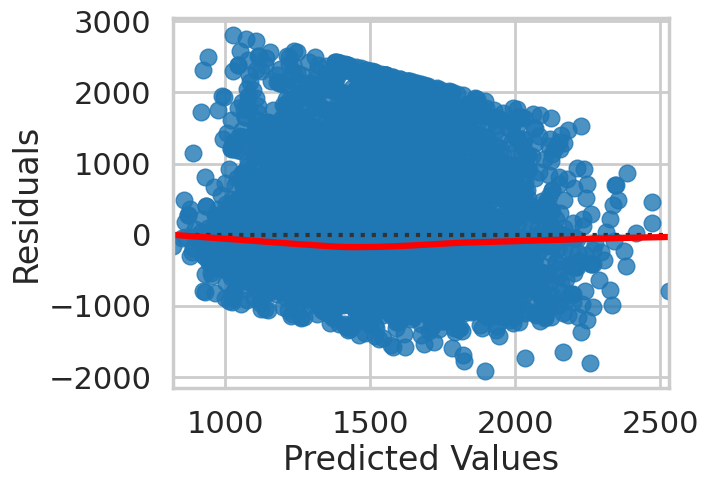

In [ ]:
y_pred = lin1_pipe.predict(X_test)
residual = y_test - y_pred
sns.residplot(x=y_pred,y=residual,lowess=True, line_kws=dict(color="r"))
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.show()

The variance of the error is not constant as some pattern can be observed from the plot. Hence, the model does not satisfy the constant variance assumption of regression.

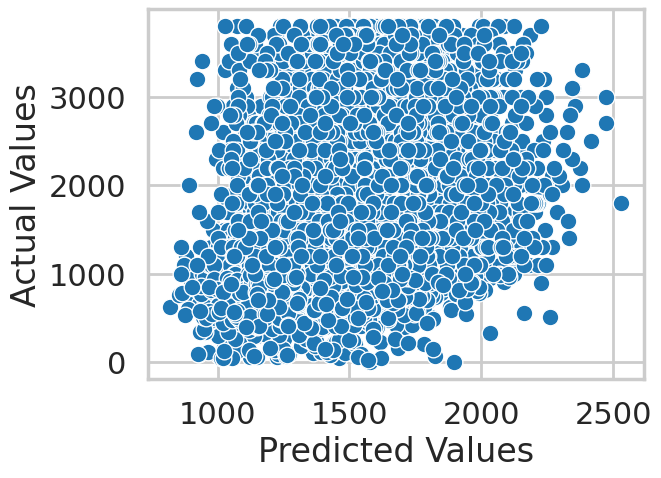

In [ ]:
sns.scatterplot(x=y_pred,y=y_test)
plt.xlabel("Predicted Values")
plt.ylabel("Actual Values")
plt.show()

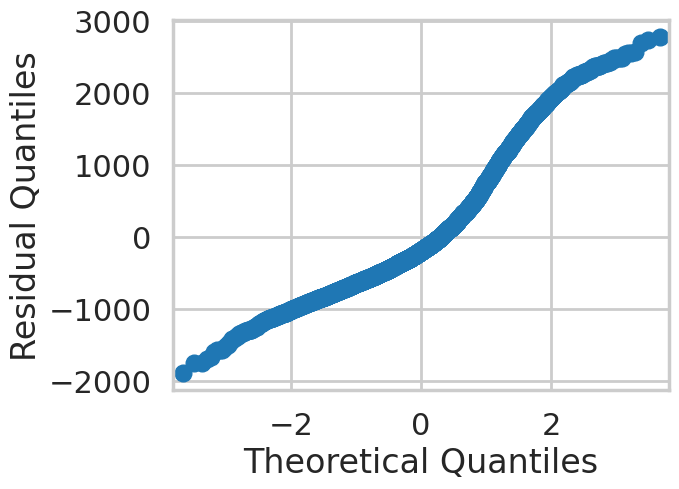

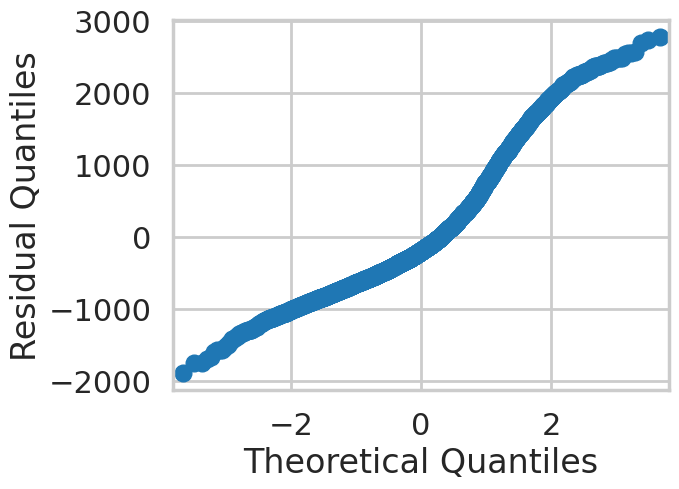

In [ ]:
sm.qqplot(residual, ylabel='Residual Quantiles')

The error is not normal either since the plot is not a roughly straight.

In [ ]:
vif_df = pd.DataFrame()
vif_df['variable'] = X_train.columns 
X_train_n = X_train.fillna(df.mean())
vif_df['VIF'] = [variance_inflation_factor(X_train_n.values, i) for i in range(X_train_n.shape[1])]
vif_df

<ipython-input-40-4bd333c7e17a>:3: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  X_train_n = X_train.fillna(df.mean())
/usr/local/lib/python3.10/dist-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


,variable,VIF
0,timedelta,2.652746e+00
1,n_tokens_title,1.134795e+00
2,n_tokens_content,3.104361e+00
3,n_unique_tokens,6.394247e+00
4,n_non_stop_words,1.936056e+00
5,n_non_stop_unique_tokens,4.392859e+00
6,num_hrefs,1.556728e+00
7,num_self_hrefs,1.350150e+00
8,num_imgs,1.464363e+00
9,num_videos,1.205260e+00


Some variables possess high VIF signifying that there is significant multicollinearity that needs to be corrected.

#### SGD Regressor

In [ ]:
sgd1_pipe = Pipeline(
    steps=[
        ('preproc', preproc),
        ('variance', VarianceThreshold()),
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler()),
        ('selector', SequentialFeatureSelector(SGDRegressor(), n_features_to_select=20, scoring='r2', cv=None)),
        ('regressor', SGDRegressor())
    ]
)

In [ ]:
sgd1_pipe.fit(X_train, y_train)

Pipeline(steps=[('preproc',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('skewed', 'drop',
                                                  [' timedelta',
                                                   ' n_unique_tokens',
                                                   ' n_non_stop_words',
                                                   ' n_non_stop_unique_tokens',
                                                   ' kw_max_min', ' kw_avg_min',
                                                   ' self_reference_min_shares',
                                                   ' kw_max_max'])])),
                ('variance', VarianceThreshold()), ('imputer', SimpleImputer()),
                ('scaler', StandardScaler()),
                ('selector',
                 SequentialFeatureSelector(cv=None, estimator=SGDRegressor(),
                                           n_features_to_select=20,
                                           scoring='r2')),
                ('regressor', SGDRegressor())])

In [ ]:
res.append(
    evaluate_model(
        'SGD Regressor (w/o Outliers)', sgd1_pipe, X_test, y_test
    )
)
res[-1]

{'model': 'SGD Regressor (w/o Outliers)',
 'r2_score': 0.11867760772892433,
 'mape': 0.8103008490862654,
 'rmse': 744.545287032143}

#### Huber Regressor

In [ ]:
hub1_pipe = Pipeline(
    steps=[
        ('preproc', preproc),
        ('variance', VarianceThreshold()),
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler()),
        ('selector', SequentialFeatureSelector(HuberRegressor(), n_features_to_select=20, scoring='r2', cv=None)),
        ('regressor', HuberRegressor())
    ]
)

In [ ]:
hub1_pipe.fit(X_train, y_train)

Pipeline(steps=[('preproc',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('skewed', 'drop',
                                                  [' timedelta',
                                                   ' n_unique_tokens',
                                                   ' n_non_stop_words',
                                                   ' n_non_stop_unique_tokens',
                                                   ' kw_max_min', ' kw_avg_min',
                                                   ' self_reference_min_shares',
                                                   ' kw_max_max'])])),
                ('variance', VarianceThreshold()), ('imputer', SimpleImputer()),
                ('scaler', StandardScaler()),
                ('selector',
                 SequentialFeatureSelector(cv=None, estimator=HuberRegressor(),
                                           n_features_to_select=20,
                                           scoring='r2')),
                ('regressor', HuberRegressor())])

In [ ]:
res.append(
    evaluate_model(
        'Huber Regressor (w/o Outliers)', hub1_pipe, X_test, y_test
    )
)
res[-1]

{'model': 'Huber Regressor (w/o Outliers)',
 'r2_score': 0.0888874312285316,
 'mape': 0.731023293139583,
 'rmse': 757.0241521005853}

In [ ]:
pd.DataFrame(res)

,model,r2_score,mape,rmse
0,Linear Regression (w/ Outliers),0.030077,1.661045,7155.587523
1,SGD Regressor (w/ Outliers),-0.069805,1.935812,7515.000072
2,Huber Regressor (w/ Outliers),-0.027290,0.685134,7364.157410
3,Linear Regression (w/o Outliers),0.122799,0.829953,742.802382
4,SGD Regressor (w/o Outliers),0.118678,0.810301,744.545287
5,Huber Regressor (w/o Outliers),0.088887,0.731023,757.024152


### Logarithmic Transformation of the Dataset

#### Linear Regression Model w/ Outliers

In [ ]:
log_df = df.apply(lambda x: np.log(x+10) if np.issubdtype(x.dtype, np.number) else x)

In [ ]:
X = log_df.drop([' shares'], axis=1)
y = df[' shares']
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.25,random_state=20)

In [ ]:
preproc = ColumnTransformer(
    transformers=[
        ('url_and_others', 'drop', ['url', ' timedelta', ' n_unique_tokens', ' n_non_stop_words', ' n_non_stop_unique_tokens', 
                                    ' kw_max_min', ' kw_avg_min', ' self_reference_min_shares']),
        #('numerical', 'passthrough', make_column_selector(dtype_include=['float64']) )
    ],
    remainder='passthrough'
)
preproc

ColumnTransformer(remainder='passthrough',
                  transformers=[('url_and_others', 'drop',
                                 ['url', ' timedelta', ' n_unique_tokens',
                                  ' n_non_stop_words',
                                  ' n_non_stop_unique_tokens', ' kw_max_min',
                                  ' kw_avg_min',
                                  ' self_reference_min_shares'])])

In [ ]:
lin2_pipe = Pipeline(
    steps=[
        ('preproc', preproc),
        ('variance', VarianceThreshold()),
        ('scaler', StandardScaler()),
        ('selector', SequentialFeatureSelector(LinearRegression(), n_features_to_select=20, scoring='r2', cv=None)),
        ('regressor', LinearRegression())
    ]
)

In [ ]:
lin2_pipe.fit(X_train, y_train)

Pipeline(steps=[('preproc',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('url_and_others', 'drop',
                                                  ['url', ' timedelta',
                                                   ' n_unique_tokens',
                                                   ' n_non_stop_words',
                                                   ' n_non_stop_unique_tokens',
                                                   ' kw_max_min', ' kw_avg_min',
                                                   ' '
                                                   'self_reference_min_shares'])])),
                ('variance', VarianceThreshold()), ('scaler', StandardScaler()),
                ('selector',
                 SequentialFeatureSelector(cv=None,
                                           estimator=LinearRegression(),
                                           n_features_to_select=20,
                                           scoring='r2')),
                ('regressor', LinearRegression())])

In [ ]:
res.append(
    evaluate_model(
        'Trasformed (w/ Outliers)', lin2_pipe, X_test, y_test
    )
)
res[-1]

{'model': 'Trasformed (w/ Outliers)',
 'r2_score': 0.02853747705503884,
 'mape': 1.7258416873847957,
 'rmse': 7161.262766942682}

#### Linear Regression Model w/o Outliers

In [ ]:
df3 = log_df.drop(columns='url').copy()
posslist = []
problist = []
for i in df3.columns:
  if df3[i].nunique() == 2:
    continue
  if i == ' shares':
    continue
  tukeys_method(df3,i,problist,posslist)

In [ ]:
df4, out_shares = target_outliers(df3)

Outlier Articles

In [76]:
df[' shares'].iloc[df.index.isin(out_shares)]

19       17100
129      19400
176      28000
270      37400
271      18000
         ...  
39486    20900
39500    25600
39537    45000
39542    16800
39621    24300
Name:  shares, Length: 1526, dtype: int64

In [113]:
X = df4.drop([' shares'], axis=1)
y = df[' shares'].iloc[~df.index.isin(out_shares)]
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.25,random_state=20)

In [ ]:
y.describe()

count    38118.000000
mean      2244.650034
std       2256.398107
min        180.000000
25%        937.000000
50%       1400.000000
75%       2500.000000
max      14100.000000
Name:  shares, dtype: float64

In [114]:
preproc = ColumnTransformer(
    transformers=[
        ('skewed', 'drop', [' timedelta', ' n_unique_tokens', ' n_non_stop_words', ' n_non_stop_unique_tokens', 
                                    ' kw_max_min', ' kw_avg_min', ' self_reference_min_shares', ' kw_max_max']),
        #('numerical', 'passthrough', make_column_selector(dtype_include=['float64']) )
    ],
    remainder='passthrough'
)
preproc

ColumnTransformer(remainder='passthrough',
                  transformers=[('skewed', 'drop',
                                 [' timedelta', ' n_unique_tokens',
                                  ' n_non_stop_words',
                                  ' n_non_stop_unique_tokens', ' kw_max_min',
                                  ' kw_avg_min', ' self_reference_min_shares',
                                  ' kw_max_max'])])

In [115]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28588 entries, 31349 to 28220
Data columns (total 59 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0    timedelta                      28176 non-null  float64
 1    n_tokens_title                 28408 non-null  float64
 2    n_tokens_content               27701 non-null  float64
 3    n_unique_tokens                27493 non-null  float64
 4    n_non_stop_words               26605 non-null  float64
 5    n_non_stop_unique_tokens       27387 non-null  float64
 6    num_hrefs                      28069 non-null  float64
 7    num_self_hrefs                 27628 non-null  float64
 8    num_imgs                       24150 non-null  float64
 9    num_videos                     26513 non-null  float64
 10   average_token_length           27448 non-null  float64
 11   num_keywords                   28523 non-null  float64
 12   data_channel_is_lifestyle  

In [132]:
lin3_pipe = Pipeline(
    steps=[
        ('preproc', preproc),
        ('imputer', SimpleImputer(strategy='mean')),
        ('variance', VarianceThreshold()),
        ('scaler', StandardScaler()),
        ('selector', SequentialFeatureSelector(LinearRegression(), n_features_to_select=20, scoring='r2', cv=None)),
        ('regressor', LinearRegression())
    ]
)

In [133]:
lin3_pipe.fit(X_train, y_train)

Pipeline(steps=[('preproc',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('skewed', 'drop',
                                                  [' timedelta',
                                                   ' n_unique_tokens',
                                                   ' n_non_stop_words',
                                                   ' n_non_stop_unique_tokens',
                                                   ' kw_max_min', ' kw_avg_min',
                                                   ' self_reference_min_shares',
                                                   ' kw_max_max'])])),
                ('imputer', SimpleImputer()), ('variance', VarianceThreshold()),
                ('scaler', StandardScaler()),
                ('selector',
                 SequentialFeatureSelector(cv=None,
                                           estimator=LinearRegression(),
                                           n_features_to_select=20,
                                           scoring='r2')),
                ('regressor', LinearRegression())])

In [111]:
res.append(
    evaluate_model(
        'Trasformed (w/o Outliers)', lin3_pipe, X_test, y_test
    )
)
res[-1]

{'model': 'Trasformed (w/o Outliers)',
 'r2_score': 0.07273648693456725,
 'mape': 0.890848621551846,
 'rmse': 2193.9583512718436}

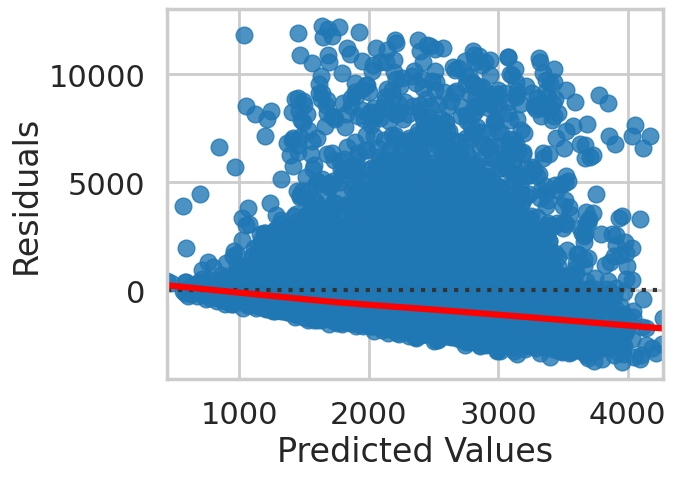

In [ ]:
y_pred = lin3_pipe.predict(X_test)
residual = y_test - y_pred
sns.residplot(x=y_pred,y=residual,lowess=True, line_kws=dict(color="r"))
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.show()

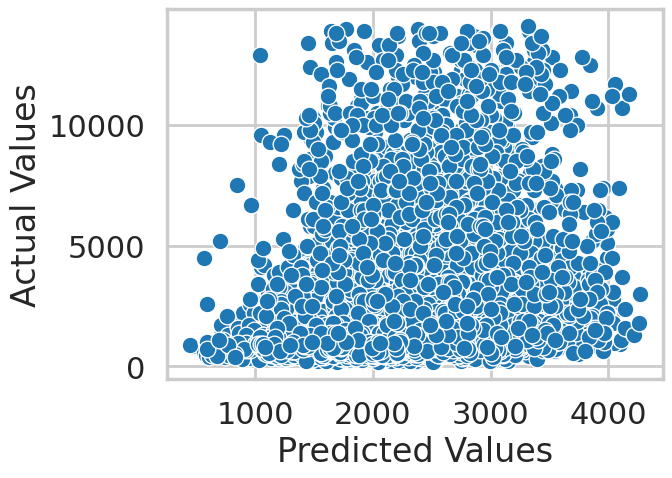

In [ ]:
sns.scatterplot(x=y_pred,y=y_test)
plt.xlabel("Predicted Values")
plt.ylabel("Actual Values")
plt.show()

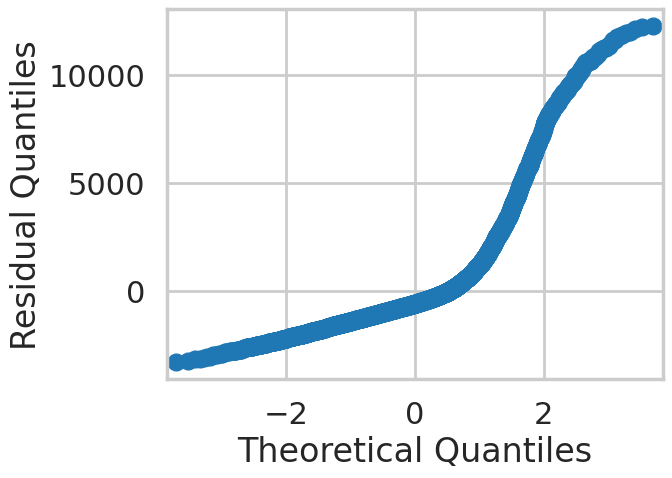

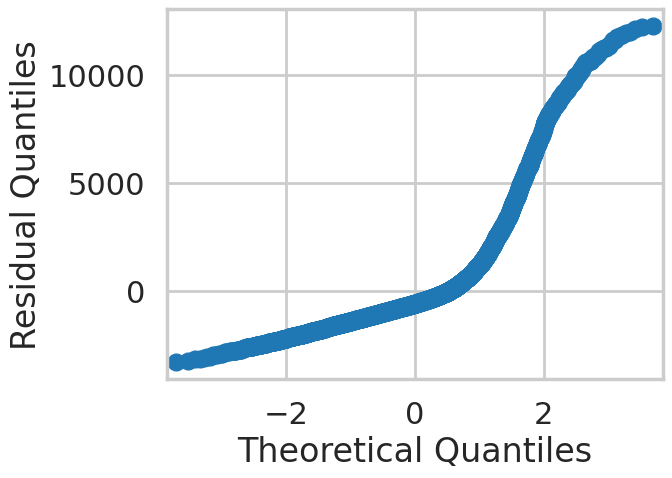

In [ ]:
sm.qqplot(residual, ylabel='Residual Quantiles')

In [ ]:
vif_df = pd.DataFrame()
vif_df['variable'] = X_train.columns 
X_train_n = X_train.fillna(df.mean())
vif_df['VIF'] = [variance_inflation_factor(X_train_n.values, i) for i in range(X_train_n.shape[1])]
vif_df

<ipython-input-67-4bd333c7e17a>:3: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  X_train_n = X_train.fillna(df.mean())
/usr/local/lib/python3.10/dist-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


,variable,VIF
0,timedelta,1.017261e+00
1,n_tokens_title,1.002514e+00
2,n_tokens_content,1.068954e+01
3,n_unique_tokens,5.115150e+00
4,n_non_stop_words,2.068863e+00
5,n_non_stop_unique_tokens,3.713542e+00
6,num_hrefs,1.194953e+00
7,num_self_hrefs,1.546259e+00
8,num_imgs,1.289935e+00
9,num_videos,1.116342e+00


In [ ]:
preproc = ColumnTransformer(
    transformers=[
        ('skewed', 'drop', [' timedelta', ' n_unique_tokens', ' n_non_stop_words', ' n_non_stop_unique_tokens', 
                            ' kw_max_min', ' kw_avg_min', ' self_reference_min_shares', ' kw_max_max', 
                            ' rate_negative_words', ' weekday_is_monday', ' weekday_is_tuesday', ' weekday_is_wednesday',
                            ' weekday_is_thursday', ' weekday_is_friday', ' weekday_is_saturday', ' weekday_is_sunday',
                            ' is_weekend', ' self_reference_min_shares']),
        #('numerical', 'passthrough', make_column_selector(dtype_include=['float64']) )
    ],
    remainder='passthrough'
)
preproc

ColumnTransformer(remainder='passthrough',
                  transformers=[('skewed', 'drop',
                                 [' timedelta', ' n_unique_tokens',
                                  ' n_non_stop_words',
                                  ' n_non_stop_unique_tokens', ' kw_max_min',
                                  ' kw_avg_min', ' self_reference_min_shares',
                                  ' kw_max_max', ' rate_negative_words',
                                  ' weekday_is_monday', ' weekday_is_tuesday',
                                  ' weekday_is_wednesday',
                                  ' weekday_is_thursday', ' weekday_is_friday',
                                  ' weekday_is_saturday', ' weekday_is_sunday',
                                  ' is_weekend',
                                  ' self_reference_min_shares'])])

In [82]:
lin4_pipe = Pipeline(
    steps=[
        ('preproc', preproc),
        ('imputer', SimpleImputer(strategy='mean')),
        ('variance', VarianceThreshold()),
        ('scaler', StandardScaler()),
        ('selector', SequentialFeatureSelector(LinearRegression(), n_features_to_select=20, scoring='r2', cv=None)),
        ('regressor', LinearRegression())
    ]
)

In [83]:
lin4_pipe.fit(X_train,y_train)

Pipeline(steps=[('preproc',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('skewed', 'drop',
                                                  [' timedelta',
                                                   ' n_unique_tokens',
                                                   ' n_non_stop_words',
                                                   ' n_non_stop_unique_tokens',
                                                   ' kw_max_min', ' kw_avg_min',
                                                   ' self_reference_min_shares',
                                                   ' kw_max_max',
                                                   ' rate_negative_words',
                                                   ' weekday_is_monday',
                                                   ' weekday_is_tuesday',
                                                   ' weekday_is_wednesday',
                                                   ' weekday_is_thursday...
                                                   ' is_weekend',
                                                   ' '
                                                   'self_reference_min_shares'])])),
                ('imputer', SimpleImputer()), ('variance', VarianceThreshold()),
                ('scaler', StandardScaler()),
                ('selector',
                 SequentialFeatureSelector(cv=None,
                                           estimator=LinearRegression(),
                                           n_features_to_select=20,
                                           scoring='r2')),
                ('debug',
                 ColumnTransformer(remainder='passthrough', transformers=[])),
                ('regressor', LinearRegression())])

In [84]:
res.append(
    evaluate_model(
        'Trasformed (w/o Outliers and High VIF)', lin4_pipe, X_test, y_test
    )
)
res[-1]

{'model': 'Trasformed (w/o Outliers and High VIF)',
 'r2_score': 0.0714473851470312,
 'mape': 0.8929024258450028,
 'rmse': 2195.4828657742814}

In [85]:
pd.DataFrame(res)

,model,r2_score,mape,rmse
0,Linear Regression (w/ Outliers),0.030077,1.661045,7155.587523
1,SGD Regressor (w/ Outliers),-0.069805,1.935812,7515.000072
2,Huber Regressor (w/ Outliers),-0.027290,0.685134,7364.157410
3,Linear Regression (w/o Outliers),0.122799,0.829953,742.802382
4,SGD Regressor (w/o Outliers),0.118678,0.810301,744.545287
5,Huber Regressor (w/o Outliers),0.088887,0.731023,757.024152
6,Trasformed (w/ Outliers),0.028537,1.725842,7161.262767
7,Trasformed (w/o Outliers),0.077460,0.880440,2188.362991
8,Trasformed (w/o Outliers and High VIF),0.071447,0.892902,2195.482866
9,Trasformed (w/o Outliers and High VIF),0.071447,0.892902,2195.482866


In [134]:
step = lin3_pipe.named_steps['selector']
index = [step.get_feature_names_out(lin3_pipe.named_steps['preproc'].get_feature_names_out(X_train.columns))]
pd.DataFrame(lin3_pipe.named_steps['regressor'].coef_, index=index)

,0
remainder__ n_tokens_content,49.801112
remainder__ num_hrefs,72.072860
remainder__ num_self_hrefs,-46.626857
remainder__ num_videos,86.423611
remainder__ data_channel_is_entertainment,-157.872462
remainder__ data_channel_is_socmed,126.765511
remainder__ data_channel_is_tech,103.788535
remainder__ data_channel_is_world,-78.461587
remainder__ kw_min_min,-35.132324
remainder__ kw_avg_max,-103.450588


Which variables are the most influential?
- Data Channel:Entertainment
- Day: Weekend
- LDA (topic): LDA 02
- What is a good range of number of words in the title? 9-12 tokens (From Summary Stats)
- Number of words in the content? 246-716 tokens (From Summary Stats)

### Hyparemetrizing the Models

In [ ]:
loss = ['squared_error', 'huber', 'epsilon_insensitive', 'squared_epsilon_insensitive']
penalty = ['l1', 'l2', 'elasticnet'] 
alpha = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000] 
learning_rate = ['constant', 'optimal', 'invscaling', 'adaptive']  
eta0 = [1, 10, 100] 
param_distributions = dict(loss=loss, penalty=penalty, alpha=alpha, learning_rate=learning_rate, eta0=eta0) 
from sklearn.model_selection import RandomizedSearchCV
imputer = SimpleImputer(strategy='mean')
X_new = X_train.drop(columns=[' timedelta', ' n_unique_tokens', ' n_non_stop_words', ' n_non_stop_unique_tokens', 
                                    ' kw_max_min', ' kw_avg_min', ' self_reference_min_shares'])
imputer.fit(X_new)
X_train_i = imputer.transform(X_new) 
sgd = SGDRegressor() 
random = RandomizedSearchCV(estimator=sgd, param_distributions=param_distributions, scoring='r2', verbose=1, n_jobs=-1, n_iter=100) 
random_result = random.fit(X_train_i, y_train) 
print('Best Score: ', random_result.best_score_) 
print('Best Params: ', random_result.best_params_) 

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best Score:  0.07477574755022978
Best Params:  {'penalty': 'l2', 'loss': 'huber', 'learning_rate': 'adaptive', 'eta0': 1, 'alpha': 0.0001}


### Feature Importance

In [ ]:
X = df.drop([' shares', 'url'], axis=1)
y = df[' shares']
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.25,random_state=20)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


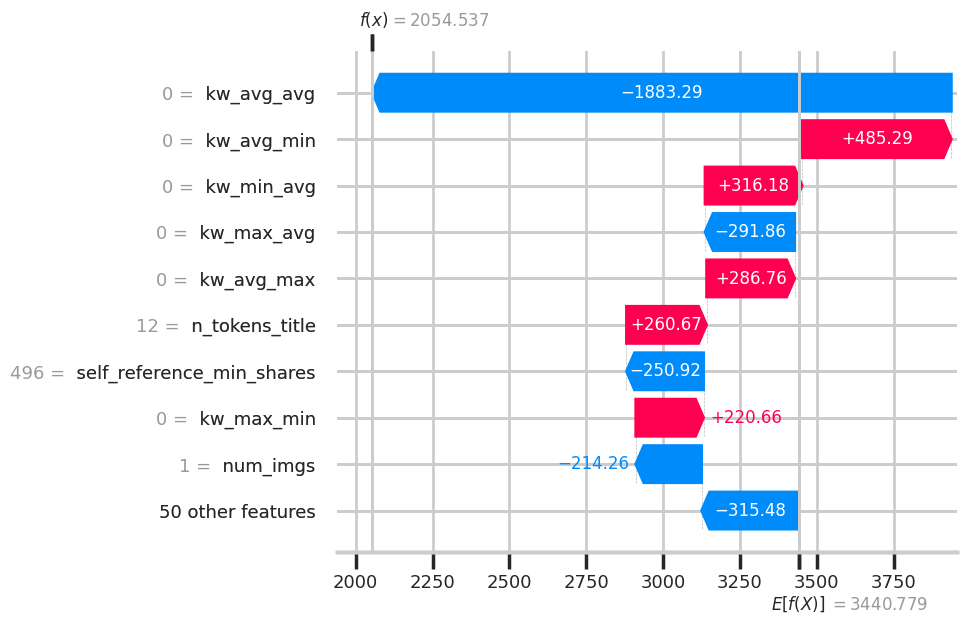

In [ ]:
import shap
import xgboost
imputer = SimpleImputer(strategy='mean')
imputer.fit(X_train)
X_train = imputer.transform(X_train)
model = xgboost.XGBRegressor().fit(X_train, y_train)
explainer = shap.Explainer(model)
shap_values = explainer(X)

# visualize the first prediction's explanation
shap.plots.waterfall(shap_values[0])